# In this notebook

Training models with Sci-Kit Learn

In [173]:
import pickle
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from rdkit import Chem
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
from tqdm import tqdm
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin

from solubility_model.models.evaluate_models import regression_model

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reproducing the best PyCaret model with default hyperparameters

In [174]:
train_data = pd.read_csv('../data/processed/train_smiles.csv')
train_desc = pd.read_csv('../data/processed/train_descriptors.csv')
test_data = pd.read_csv('../data/processed/test_smiles.csv')
test_desc = pd.read_csv('../data/processed/test_descriptors.csv')

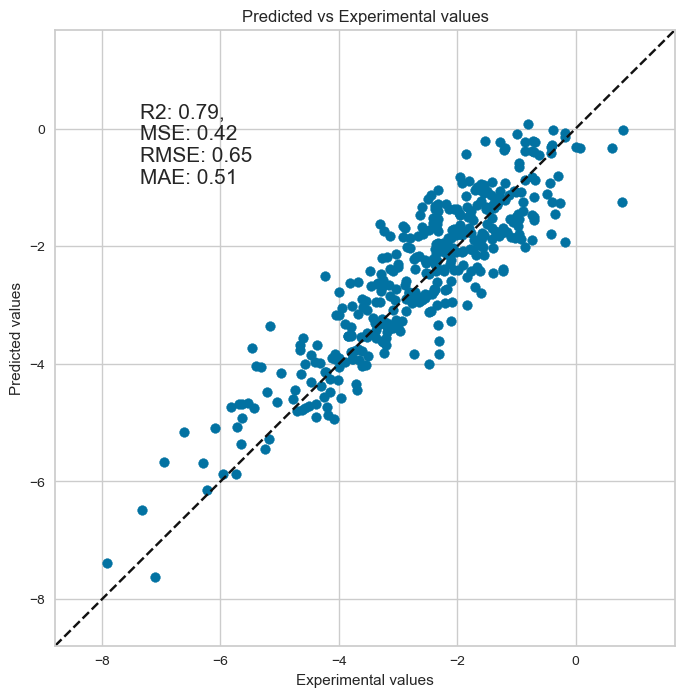

In [175]:
hgbr = ExtraTreesRegressor()
hgbr.fit(train_desc, train_data.y_true)
y_pred = hgbr.predict(test_desc)
regression_model(test_data.y_true, pd.Series(y_pred))

metrics = []
metrics.append({
    "model_name" : "default parameters",
    "n_estimators" : 100,
    "max_depth" : None,
    "min_samples_split" : 2,
    "min_samples_leaf" : 1,
    "R2": r2_score(test_data.y_true, y_pred),
    "MSE": mean_squared_error(test_data.y_true, y_pred),
    "RMSE": mean_squared_error(test_data.y_true, y_pred, squared=False),
    "MAE": mean_absolute_error(test_data.y_true, y_pred),
})

## Hyperparameter tuning with a grid search

In [156]:
# For train validation split
mols = [Chem.MolFromSmiles(x) for x in train_data.smiles]
scaffolds = [Chem.MolToSmiles(GetScaffoldForMol(mol)) for mol in mols]

# Define hyperparameter space
params_list = []
for n_estimators in [50, 100, 200, 300, 400]:
    for max_depth in [None, 20, 30, 50, 100]:
        for min_samples_split in [2, 3, 5, 10, 20]:
            for min_samples_leaf in [1, 2, 3, 5, 10]:
                params_list.append({
                    "n_estimators" : n_estimators,
                    "max_depth" : max_depth,
                    "min_samples_split" : min_samples_split,
                    "min_samples_leaf" : min_samples_leaf
                })

# Set up the k-fold cross-validation
gss = GroupShuffleSplit(n_splits=5, train_size=0.8, random_state=0)
fold_indicies = list(gss.split(train_data.smiles, groups=scaffolds))

# Hyperparameters
performances = []

# Train models
for params in tqdm(params_list):
    for (train_index, valid_index) in fold_indicies:
        # Select data for training and validation
        X_train = train_desc.iloc[train_index]
        y_train = train_data.y_true.iloc[train_index]

        X_valid = train_desc.iloc[valid_index]
        y_valid = train_data.y_true.iloc[valid_index]

        # Train model
        classifier = ExtraTreesRegressor(
            **params
            )
        classifier.fit(
            X_train, 
            y_train, 
        )

        y_pred = classifier.predict(X_valid)

        data = {
            "n_estimators" : params["n_estimators"],
            "max_depth" : params["max_depth"],
            "min_samples_split" : params["min_samples_split"],
            "min_samples_leaf" : params["min_samples_leaf"],
            "R2": r2_score(y_valid, y_pred),
            "MSE": mean_squared_error(y_valid, y_pred),
            "RMSE": mean_squared_error(y_valid, y_pred, squared=False),
            "MAE": mean_absolute_error(y_valid, y_pred),
        }
        performances.append(data)

100%|██████████| 625/625 [00:03<00:00, 172.53it/s]


In [164]:
# Group by hyperparameters and average metrics across 5-fold CV
metrics_df = pd.DataFrame(performances)
best = metrics_df.groupby(["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf"], dropna=False).agg(["mean"]).sort_values(("R2", "mean"), ascending=False)
metrics_df.groupby(["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf"], dropna=False).agg(["mean"]).sort_values(("R2", "mean"), ascending=False).head(5)

R2       MSE  \
                                                               mean      mean   
n_estimators max_depth min_samples_split min_samples_leaf                       
50           20.0      3                 3                 0.844348  0.575284   
             50.0      5                 2                 0.842598  0.580701   
             30.0      20                3                 0.842388  0.585706   
200          50.0      5                 1                 0.842064  0.584239   
100          NaN       2                 1                 0.841255  0.587035   

                                                               RMSE       MAE  
                                                               mean      mean  
n_estimators max_depth min_samples_split min_samples_leaf                      
50           20.0      3                 3                 0.745761  0.592369  
             50.0      5                 2                 0.751926  0.589910  
             30.0      20                3                 0.751570  0.596957  
200          50.0      5                 1                 0.750438  0.592234  
100          NaN       2                 1                 0.754546  0.599163

## Finalizing grid-search optimized model

In [176]:
params = best.reset_index().iloc[:, :4]
params.columns = ["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf"]
params = params.to_dict(orient="records")[0]

# Tidy params
for key in params:
    try:
        params[key] = int(params[key])
    except ValueError:
        params[key] = None

params

{'n_estimators': 50,
 'max_depth': 20,
 'min_samples_split': 3,
 'min_samples_leaf': 3}

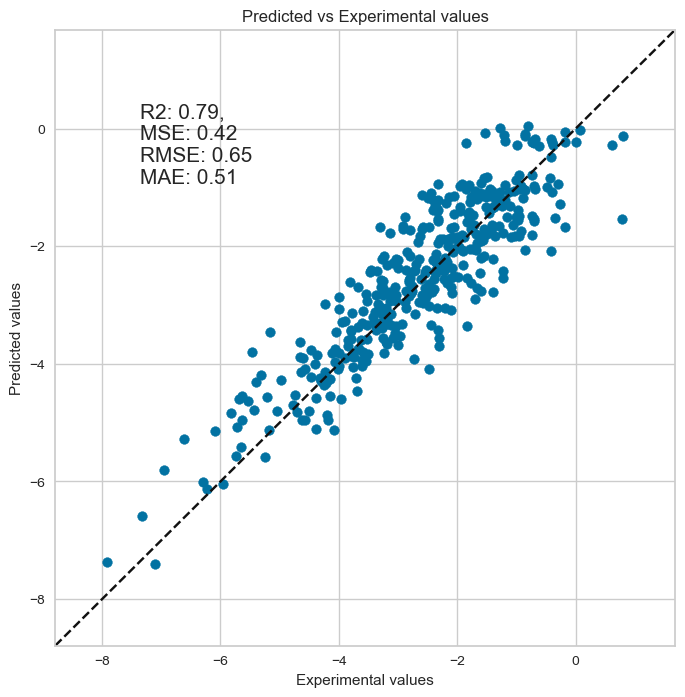

In [177]:
hgbr = ExtraTreesRegressor(**params)
hgbr.fit(train_desc, train_data.y_true)
y_pred = hgbr.predict(test_desc)
regression_model(test_data.y_true, pd.Series(y_pred))

metrics.append({
    "model_name" : "grid search optimized",
    "n_estimators" : params["n_estimators"],
    "max_depth" : params["max_depth"],
    "min_samples_split" : params["min_samples_split"],
    "min_samples_leaf" : params["min_samples_leaf"],
    "R2": r2_score(test_data.y_true, y_pred),
    "MSE": mean_squared_error(test_data.y_true, y_pred),
    "RMSE": mean_squared_error(test_data.y_true, y_pred, squared=False),
    "MAE": mean_absolute_error(test_data.y_true, y_pred),
})

In [178]:
d_r2 = metrics[0]['R2']
grid_r2 = metrics[1]['R2']
print(f"After hyperparameter optimization, R2: {grid_r2:.3f}, with default params: {d_r2:.3f}, a {(grid_r2-d_r2)/d_r2*100:.2f}% improvement")

After hyperparameter optimization, R2: 0.791, with default params: 0.795, a -0.44% improvement


## Baysian hyperparameter tuning using Hyperopt

In [180]:
# Define hyperparameter space
space = {
    "n_estimators" : hp.quniform("n_estimators", 50, 400, 1), 
    "max_depth" : hp.quniform("max_depth", 10, 100, 1),
    "min_samples_split" : hp.quniform("min_samples_split", 2, 20, 1),
    "min_samples_leaf" : hp.quniform("min_samples_leaf", 1, 10, 1),
}

# Hyperparameters
hyp_performances = []


# Objective function
def objective(params):
    # Sometimes hyperopt gives params as float which causes issues
    for key in params:
        params[key] = int(params[key])
    
    scores = []
    for (train_index, valid_index) in fold_indicies:
        # Select data for training and validation
        X_train = train_desc.iloc[train_index]
        y_train = train_data.y_true.iloc[train_index]

        X_valid = train_desc.iloc[valid_index]
        y_valid = train_data.y_true.iloc[valid_index]

        # Train model
        classifier = ExtraTreesRegressor(
            **params
            )
        classifier.fit(
            X_train, 
            y_train, 
        )

        y_pred = classifier.predict(X_valid)

        data = {
            "n_estimators" : params["n_estimators"],
            "max_depth" : params["n_estimators"],
            "min_samples_split" : params["n_estimators"],
            "min_samples_leaf" : params["n_estimators"],
            "R2": r2_score(y_valid, y_pred),
            "MSE": mean_squared_error(y_valid, y_pred),
            "RMSE": mean_squared_error(y_valid, y_pred, squared=False),
            "MAE": mean_absolute_error(y_valid, y_pred),
        }
        hyp_performances.append(data)

        # Score for fold
        scores.append(r2_score(y_valid, y_pred))
    
    # Average score across 5-folds
    score = sum(scores)/len(scores)
    
    # Loss is 1 - score (minimizes loss)
    loss = 1 - score
    
    # Return loss to hyperopt
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

# Optimize
best_params = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 300, trials = Trials())

  2%|▏         | 5/300 [01:10<1:08:53, 14.01s/trial, best loss: 0.1611820652425875]


KeyboardInterrupt: 

In [ ]:
# Group by hyperparameters and average metrics across 5-fold CV
hyp_metrics_df = pd.DataFrame(hyp_performances)
hyp_best = hyp_metrics_df.groupby(["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf"], dropna=False).agg(["mean"]).sort_values(("R2", "mean"), ascending=False).head(1)
hyp_metrics_df.groupby(["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf"], dropna=False).agg(["mean"]).sort_values(("R2", "mean"), ascending=False).head(5)

## Finalizing hyperopt model

In [ ]:
params = hyp_best.reset_index().iloc[:, :4]
params.columns = ["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf"]
params = params.to_dict(orient="records")[0]

# Tidy params
for key in params:
    try:
        params[key] = int(params[key])
    except ValueError:
        params[key] = None

params

NameError: name 'hyp_best' is not defined

In [ ]:
hgbr = ExtraTreesRegressor(**params)
hgbr.fit(train_desc, train_data.y_true)
y_pred = hgbr.predict(test_desc)
regression_model(test_data.y_true, pd.Series(y_pred))

metrics.append({
    "model_name" : "hyperopt optimized",
    "n_estimators" : params["n_estimators"],
    "max_depth" : params["max_depth"],
    "min_samples_split" : params["min_samples_split"],
    "min_samples_leaf" : params["min_samples_leaf"],
    "R2": r2_score(test_data.y_true, y_pred),
    "MSE": mean_squared_error(test_data.y_true, y_pred),
    "RMSE": mean_squared_error(test_data.y_true, y_pred, squared=False),
    "MAE": mean_absolute_error(test_data.y_true, y_pred),
})

In [ ]:
d_r2 = metrics[0]['R2']
hyp_r2 = metrics[2]['R2']
print(f"After hyperparameter optimization, R2: {hyp_r2:.3f}, with default params: {d_r2:.3f}, a {(hyp_r2-d_r2)/d_r2*100:.2f}% improvement")

IndexError: list index out of range

In [ ]:
pd.DataFrame(metrics)

,model_name,n_estimators,max_depth,min_samples_split,min_samples_leaf,R2,MSE,RMSE,MAE
0,grid search optimized,50,50,50,50,0.68448,0.642890,0.801804,0.622672
1,grid search optimized,50,50,50,50,0.65889,0.695032,0.833686,0.658595
